# Running Chronos on AutoGluon TimeSeries

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/timeseries/forecasting-chronos.ipynb)

With AutoGluon v1.1, AutoGluon-TimeSeries (AG-TS) now features [Chronos](https://github.com/amazon-science/chronos-forecasting), a family of pretrained time series forecasting models. Chronos models are based on language model architectures, and work by quantizing time series into buckets which are treated as tokens. Language models were then trained on these token sequences using cross-entropy loss. 
The current iteration of Chronos models, [available](https://huggingface.co/amazon/chronos-t5-large) on Hugging Face 🤗, are based on the T5 architecture and were trained on a large corpus of open-source time series data augmented with synthetic data generation techniques. The Chronos [paper](https://arxiv.org/abs/2403.07815) provides greater detail about the models and how they were trained. 

AG-TS provides a robust and easy way to use Chronos, as well as combine it with other powerful time series models to build highly accurate ensembles for forecasting. 
Chronos is available through the same familiar AG-TS API, and is part of `"best_quality"` and `"high_quality"` presets of `TimeSeriesPredictor`. 
Moreover, the `TimeSeriesPredictor` now supports custom presets for working with Chronos standalone. 

In [ ]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab

In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Getting Started with Chronos

Chronos is available in 5 model sizes. These are `tiny`, `mini`, `small`, `base` and `large`, and are encoder-decoder transformer models with 8M, 20M, 46M, 200M and 710M parameters respectively. Being pretrained models primarily for zero-shot forecasting (that is, forecasting new time series without any parameter learning), Chronos is different from other models available in AG-TS. 
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they have to carry out relatively more expensive computation that scales with the number of time series that should be forecasted. In this respect, they behave like local statistical models such as ETS or ARIMA, where the expensive computation happens during inference. Differently from statistical models, however, computation in the larger Chronos models requires an accelerator chip to run in a reasonable amount of time.

The easiest way to get started with Chronos on the `TimeSeriesPredictor` is through model-specific presets. As of v1.1, the `TimeSeriesPredictor.fit` method has chronos presets specific to the model size, such as `chronos_small`, or `chronos_base`. There are also two more presets that allow ensembling Chronos with the rest of AG-TS's best models: `chronos_ensemble` and `chronos_large_ensemble`, which include Chronos-small and Chronos-large respectively. Finally, the `high_quality` and `best_quality` presets include Chronos-base.

Note that the `TimeSeriesPredictor` will refuse to run model sizes larger than `mini` without a GPU. However, we can experiment with `tiny` and `mini` on the CPU as well. 

Let's work with a subset of the M4 competition data set to see Chronos in action.

In [7]:
df = TimeSeriesDataFrame(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv"
)
df.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [24]:
training_window = df.slice_by_timestep(start_index=None, end_index=-5)
predictor = TimeSeriesPredictor(prediction_length=5).fit(
    training_window, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240414_115522'
=================== System Info ===================
AutoGluon Version:  1.1.0b20240412
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Mar 26 20:11:48 UTC 2024
CPU Count:          48
GPU Count:          0
Memory Avail:       167.94 GB / 184.62 GB (91.0%)
Disk Space Avail:   432.34 GB / 1968.52 GB (22.0%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 147060 rows, 200 time


AutoGluon will gauge predictive performance using evaluation metric: 'WQL'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2024-04-14 11:55:22
Models that will be trained: ['Chronos[tiny]']
Training timeseries model Chronos[tiny]. 
	0.04    s     = Training runtime
Training complete. Models trained: ['Chronos[tiny]']
Total runtime: 0.05 s
Best model: Chronos[tiny]


As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series, caching data and saving the predictor's state. 

Let's use the predictor to generate forecasts, and the `TimeSeriesPredictor.plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


CPU times: user 4min 43s, sys: 1min 50s, total: 6min 34s
Wall time: 18.2 s


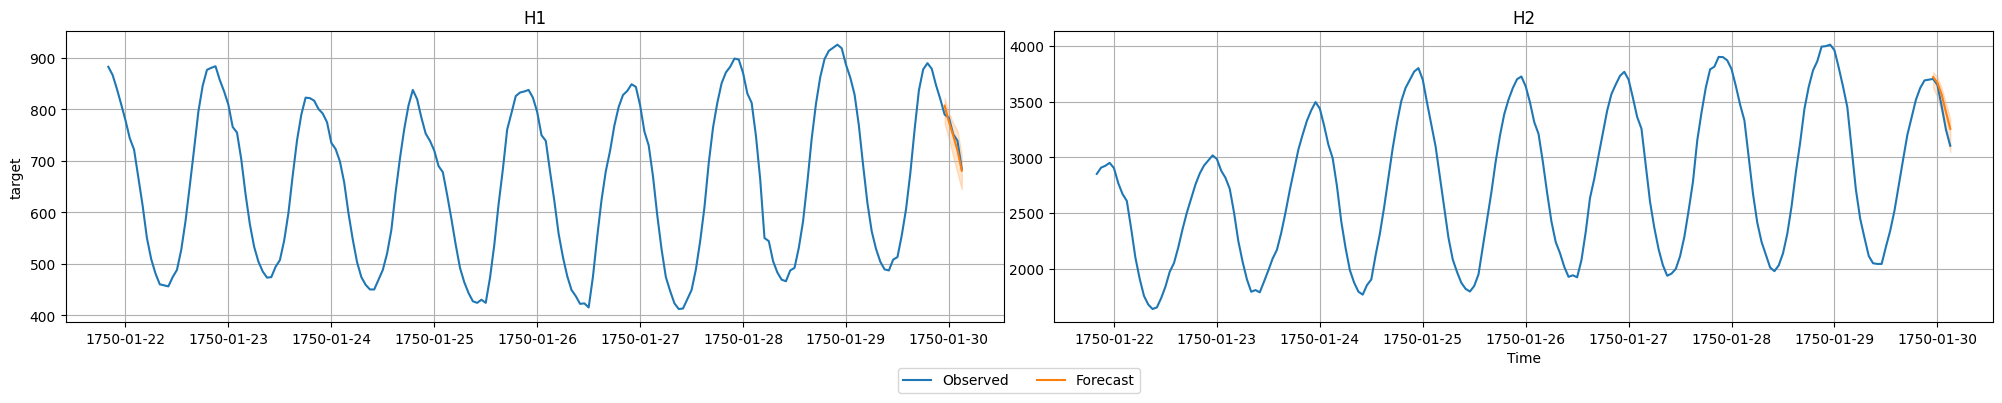

In [25]:
%%time
predictions = predictor.predict(training_window)
predictor.plot(
    data=df.slice_by_timestep(-200, None), 
    predictions=predictions, 
    item_ids=["H1", "H2"],
)

## Configuring for Performance

Looks good! The data set has 200 items, so Chronos-tiny takes less than half a second for each forecast. As with all large deep learning models, however, some fine-grained control of inference parameters can be needed to both optimize performance and avoid out-of-memory issues. For this, we will need to dive a bit deeper, configuring `hyperparameters` of the `TimeSeriesPredictor` directly.  

In [36]:
%%time
predictions = TimeSeriesPredictor(prediction_length=5).fit(
    training_window,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "torch_dtype": "bfloat16",
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
).predict(
    training_window,
)

CPU times: user 4min 24s, sys: 1min 15s, total: 5min 39s
Wall time: 18 s


Above, we explicitly told `TimeSeriesPredictor` to skip running backtests during `fit` via `skip_model_selection=True`, as we will only consider a single model.
In `hyperparameters`, `batch_size` configures the number of time series used per batch during inference. 
`torch_dtype="bfloat16"` instructs Chronos to use half-precision floating point for reduced memory footprint.
On the GPU, and for larger model sizes, these parameters can greatly improve inference performance for Chronos based on the hardware used.

On the CPU, the adjustments above appear to be helping only very slightly. However, the AutoGluon implementation of Chronos also supports using deep learning compilers which improve performance on Intel CPUs. Providing the `optimization_strategy="openvino"` hyperparameter instructs AutoGluon to first convert Chronos for use with the [OpenVINO](https://github.com/openvinotoolkit/openvino) runtime. Note that this requires installing autogluon timeseries with 

```bash
pip install "autogluon.timeseries[chronos-openvino]"
```

and is not installed by default.

Below, we use two tricks. We first `fit` and `persist` the model. The `TimeSeriesPredictor.persist` method tells AutoGluon to prepare Chronos for OpenVINO and keep it in device memory for fast, on-demand inference. `optimization_strategy="openvino"` tells Chronos to work with OpenVINO. Behind the scenes, AutoGluon will use Hugging Face [optimum](https://github.com/huggingface/optimum-intel) for this conversion. 

In [52]:
%%capture
predictor = TimeSeriesPredictor(prediction_length=5).fit(
    training_window,
    hyperparameters={
        "Chronos": {
            "model_path": "tiny",
            "batch_size": 64,
            "device": "cpu",
            "optimization_strategy": "openvino",
        }
    },
    verbosity=0,
    skip_model_selection=True,
)
predictor.persist()

In [51]:
%%time
predictions = predictor.predict(training_window)

CPU times: user 1min 25s, sys: 18.8 s, total: 1min 44s
Wall time: 8.02 s


That seems to have cut the inference time by more than half!

We could have also used the ONNX runtime by providing `optimization_strategy="onnx"`. For a discussion of these and other hyperparameters of Chronos, see the Chronos model [documentation](forecasting-model-zoo.md).